# importing helper function file

In [4]:
!wget https://raw.githubusercontent.com/moamen1358/helper_functions_moamen/main/mmm.py

--2024-05-02 18:48:05--  https://raw.githubusercontent.com/moamen1358/helper_functions_moamen/main/mmm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10911 (11K) [text/plain]
Saving to: 'mmm.py'

mmm.py              100%[===================>]  10.66K  --.-KB/s    in 0s      

2024-05-02 18:48:05 (57.4 MB/s) - 'mmm.py' saved [10911/10911]



# import needed library

In [5]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras import layers
from mmm import plot_loss_curves, walk_through_dir,create_tensorboard_callback,compare_historys,image_number_in_dir,unzip_data
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-05-02 18:48:08.092555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 18:48:08.092657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 18:48:08.217961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# importing the balanced weather dataset:
## link :https://www.kaggle.com/datasets/hanahelaly/new-weather-ds


In [6]:
!kaggle datasets download -d hanahelaly/new-weather-ds

Dataset URL: https://www.kaggle.com/datasets/hanahelaly/new-weather-ds
License(s): Apache 2.0
 97%|███████████████████████████████████████▉ | 684M/703M [00:04<00:00, 145MB/s]
100%|█████████████████████████████████████████| 703M/703M [00:04<00:00, 155MB/s]


In [7]:
unzip_data('new-weather-ds.zip')

In [8]:
walk_through_dir('new dataset')

There are 2 directories and 0 images in 'new dataset'.
There are 11 directories and 0 images in 'new dataset/test'.
There are 0 directories and 91 images in 'new dataset/test/frost'.
There are 0 directories and 75 images in 'new dataset/test/lightning'.
There are 0 directories and 116 images in 'new dataset/test/sandstorm'.
There are 0 directories and 229 images in 'new dataset/test/rime'.
There are 0 directories and 204 images in 'new dataset/test/fogsmog'.
There are 0 directories and 136 images in 'new dataset/test/dew'.
There are 0 directories and 110 images in 'new dataset/test/hail'.
There are 0 directories and 117 images in 'new dataset/test/snow'.
There are 0 directories and 127 images in 'new dataset/test/glaze'.
There are 0 directories and 154 images in 'new dataset/test/rain'.
There are 0 directories and 68 images in 'new dataset/test/rainbow'.
There are 11 directories and 0 images in 'new dataset/train'.
There are 0 directories and 1082 images in 'new dataset/train/frost'.
T

In [9]:
train_path = '/kaggle/working/new dataset/train'
test_path = '/kaggle/working/new dataset/test'

In [10]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                                            validation_split=.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

In [11]:
image_shape = (224,224,3)
batch_size = 32
epochs = 100
no_classes = 11

In [12]:
train_data_set = train_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset = 'training')

validation_data_set = train_gen.flow_from_directory(train_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset = 'validation')



Found 8988 images belonging to 11 classes.
Found 2241 images belonging to 11 classes.


In [13]:
test_data_set = test_gen.flow_from_directory(test_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)


Found 1427 images belonging to 11 classes.


In [14]:
class_names = os.listdir(train_path)

In [15]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_random_images(data_path, class_names, num_images=10):
    """
    Visualizes random images from the specified data path.

    Args:
        data_path (str): Path to the directory containing subfolders for each class.
        class_names (list): List of class names (folder names).
        num_images (int): Number of images to visualize (default is 10).
    """
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        class_name = random.choice(class_names)
        class_folder = os.path.join(data_path, class_name)
        image_file = random.choice(os.listdir(class_folder))
        image_path = os.path.join(class_folder, image_file)

        img = mpimg.imread(image_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()



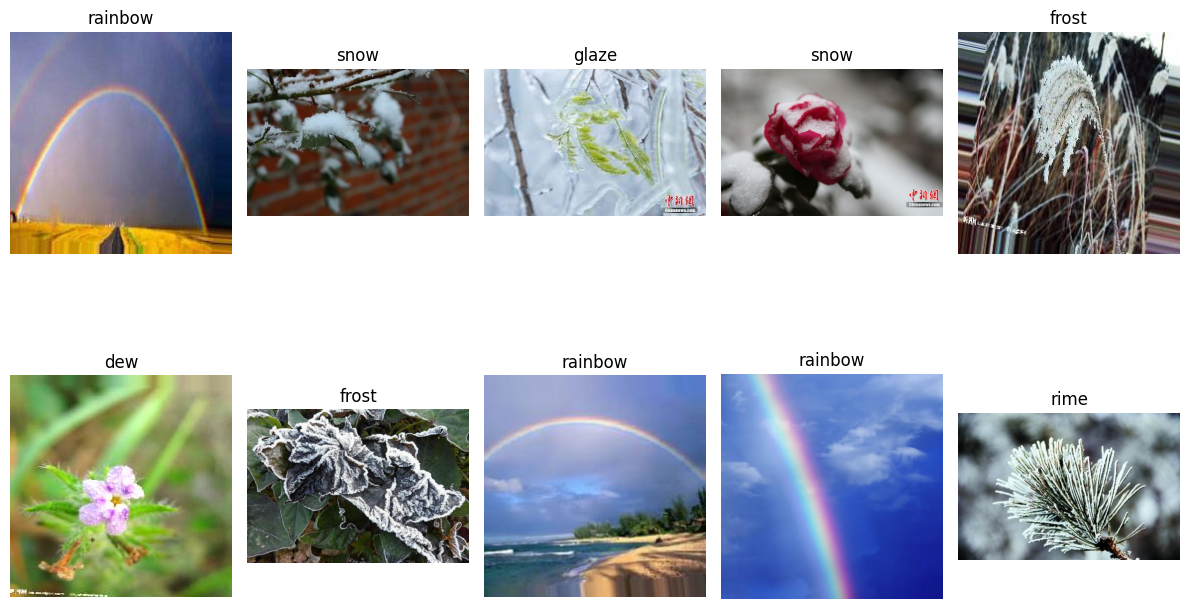

In [16]:
visualize_random_images(train_path, class_names)


# now we get our data ::
## lets build our model using MobileNet as layer in our model


In [11]:
base_model = tf.keras.applications.MobileNet(input_shape=[224,224,3], weights="imagenet", include_top=False)

base_model.trainable = False
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False


inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

model_aug = base_model(inputs)
model_aug = Flatten()(model_aug)
model_aug = Dense(units=1024, activation="relu")(model_aug)
model_aug = Dense(units=1024, activation="relu")(model_aug)
model_aug = Dense(units=512, activation="relu")(model_aug)


prediction_layer = Dense(units=11, activation="softmax")(model_aug)

model_aug = Model(inputs=inputs, outputs=prediction_layer)

model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


17225924/17225924 [==============================] - 2s 0us/step


In [12]:
for layer in base_model.layers:
  print(layer,layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7852020c2320> False

<keras.src.layers.convolutional.conv2d.Conv2D object at 0x785201f11900> False

<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x785201f11060> False

<keras.src.layers.activation.relu.ReLU object at 0x785201f10670> False

<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x785201f0e590> False

<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x785201f0f790> False

<keras.src.layers.activation.relu.ReLU object at 0x785201f0faf0> False

<keras.src.layers.convolutional.conv2d.Conv2D object at 0x785201f0d210> False

<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x785201f0cbe0> False

<keras.src.layers.activation.relu.ReLU object at 0x785201f0e050> False

<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7852020ff100> False

<keras.src.layers.convolutional.depthwise_conv2d.Dep

In [ ]:
history_no_train = model_aug.fit(train_data_set,
                                       validation_data=validation_data_set,
                                       batch_size=batch_size,
                                       epochs=20,
                                       callbacks=create_tensorboard_callback('transfer_learning','weather'))

Saving TensorBoard log files to: transfer_learning/weather/20240502-123546

Epoch 1/20

141/141 [==============================] - 43s 284ms/step - loss: 3.1717 - accuracy: 0.7480 - val_loss: 2.6652 - val_accuracy: 0.5846

Epoch 2/20

141/141 [==============================] - 39s 280ms/step - loss: 0.1608 - accuracy: 0.9523 - val_loss: 0.4781 - val_accuracy: 0.8643

Epoch 3/20

141/141 [==============================] - 39s 279ms/step - loss: 0.0808 - accuracy: 0.9751 - val_loss: 0.6807 - val_accuracy: 0.8452

Epoch 4/20

141/141 [==============================] - 39s 279ms/step - loss: 0.0563 - accuracy: 0.9828 - val_loss: 0.6617 - val_accuracy: 0.8505

Epoch 5/20

141/141 [==============================] - 39s 277ms/step - loss: 0.1022 - accuracy: 0.9713 - val_loss: 0.6391 - val_accuracy: 0.8496

Epoch 6/20

141/141 [==============================] - 39s 276ms/step - loss: 0.0414 - accuracy: 0.9871 - val_loss: 0.6387 - val_accuracy: 0.8679

Epoch 7/20

141/141 [=====================

In [ ]:
model_aug.evaluate(test_data_set)

23/23 [==============================] - 7s 297ms/step - loss: 1.0594 - accuracy: 0.8367


[1.059378981590271, 0.8367204070091248]

In [ ]:
base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

base_model.trainable = False
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False


inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

x = base_model(inputs)
x = Flatten()(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=512, activation='relu')(x)

outputs = Dense(units=11, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_history = model.fit(train_data_set,
                            validation_data=validation_data_set,
                            batch_size=batch_size,
                            epochs=20,
                            callbacks=create_tensorboard_callback('transfer_learning','weather_model'))

Saving TensorBoard log files to: transfer_learning/weather_model/20240502-125331

Epoch 1/20

141/141 [==============================] - 44s 285ms/step - loss: 3.2495 - accuracy: 0.6481 - val_loss: 0.5872 - val_accuracy: 0.8126

Epoch 2/20

141/141 [==============================] - 38s 268ms/step - loss: 0.7138 - accuracy: 0.7932 - val_loss: 0.4952 - val_accuracy: 0.8438

Epoch 3/20

141/141 [==============================] - 39s 279ms/step - loss: 0.6415 - accuracy: 0.8269 - val_loss: 0.4968 - val_accuracy: 0.8478

Epoch 4/20

141/141 [==============================] - 39s 277ms/step - loss: 0.5645 - accuracy: 0.8487 - val_loss: 0.5039 - val_accuracy: 0.8639

Epoch 5/20

141/141 [==============================] - 39s 275ms/step - loss: 0.6151 - accuracy: 0.8589 - val_loss: 0.4810 - val_accuracy: 0.8693

Epoch 6/20

141/141 [==============================] - 39s 274ms/step - loss: 0.7017 - accuracy: 0.8597 - val_loss: 0.5613 - val_accuracy: 0.8577

Epoch 7/20

141/141 [===============

In [ ]:
model.evaluate(test_data_set)

23/23 [==============================] - 7s 281ms/step - loss: 0.6178 - accuracy: 0.8514


[0.6177917718887329, 0.8514365553855896]

# unfreeze the last five layers from our MobilNet model

In [13]:
# Load MobileNet as the base model
base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top=False)


base_model.trainable = False
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False


# Define the model architecture
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = Flatten()(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=512, activation='relu')(x)
outputs = Dense(units=11, activation='softmax')(x)

model2 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up model checkpoint to save best weights
checkpoint_callback = ModelCheckpoint(filepath='best_model_weights.h5',
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='max',
                                      verbose=1)

# Train the model
history = model2.fit(train_data_set,
                     epochs=20,
                     validation_data=validation_data_set,
                     callbacks=[checkpoint_callback])


Epoch 1/20

141/141 [==============================] - ETA: 0s - loss: 2.7193 - accuracy: 0.7153

Epoch 1: val_accuracy improved from -inf to 0.75770, saving model to best_model_weights.h5

141/141 [==============================] - 52s 311ms/step - loss: 2.7193 - accuracy: 0.7153 - val_loss: 1.0326 - val_accuracy: 0.7577

Epoch 2/20

141/141 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.8655

Epoch 2: val_accuracy improved from 0.75770 to 0.81705, saving model to best_model_weights.h5

141/141 [==============================] - 39s 276ms/step - loss: 0.4758 - accuracy: 0.8655 - val_loss: 0.6120 - val_accuracy: 0.8170

Epoch 3/20

141/141 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8973

Epoch 3: val_accuracy improved from 0.81705 to 0.82419, saving model to best_model_weights.h5

141/141 [==============================] - 39s 280ms/step - loss: 0.3866 - accuracy: 0.8973 - val_loss: 0.6474 - val_accuracy: 0.8242

Epoch 4/20

141/141

In [14]:
model2.evaluate(test_data_set)

23/23 [==============================] - 7s 305ms/step - loss: 0.9537 - accuracy: 0.8367


[0.9536701440811157, 0.8367204070091248]

In [15]:
model2.load_weights('best_model_weights.h5')


In [16]:
model2.evaluate(test_data_set)

23/23 [==============================] - 6s 277ms/step - loss: 0.7804 - accuracy: 0.8542


[0.7804261445999146, 0.8542396426200867]

# trying to fit the model with freezing the base model

In [17]:
# Load MobileNet as the base model
base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top=False)


base_model.trainable = False

# Define the model architecture
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = Flatten()(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=512, activation='relu')(x)
outputs = Dense(units=11, activation='softmax')(x)

model2 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up model checkpoint to save best weights
checkpoint_callback = ModelCheckpoint(filepath='best_model2_weights.h5',
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='max',
                                      verbose=1)

# Train the model
history = model2.fit(train_data_set,
                     epochs=20,
                     validation_data=validation_data_set,
                     callbacks=[checkpoint_callback])


Epoch 1/20

141/141 [==============================] - ETA: 0s - loss: 3.4759 - accuracy: 0.6646

Epoch 1: val_accuracy improved from -inf to 0.85944, saving model to best_model2_weights.h5

141/141 [==============================] - 46s 310ms/step - loss: 3.4759 - accuracy: 0.6646 - val_loss: 0.4483 - val_accuracy: 0.8594

Epoch 2/20

141/141 [==============================] - ETA: 0s - loss: 0.6329 - accuracy: 0.8159

Epoch 2: val_accuracy did not improve from 0.85944

141/141 [==============================] - 39s 278ms/step - loss: 0.6329 - accuracy: 0.8159 - val_loss: 0.4692 - val_accuracy: 0.8563

Epoch 3/20

141/141 [==============================] - ETA: 0s - loss: 0.5530 - accuracy: 0.8594

Epoch 3: val_accuracy did not improve from 0.85944

141/141 [==============================] - 39s 279ms/step - loss: 0.5530 - accuracy: 0.8594 - val_loss: 0.5018 - val_accuracy: 0.8568

Epoch 4/20

141/141 [==============================] - ETA: 0s - loss: 0.4972 - accuracy: 0.8669

Epoch 

In [18]:
model2.evaluate(test_data_set)

23/23 [==============================] - 7s 300ms/step - loss: 0.5233 - accuracy: 0.8725


[0.5232610106468201, 0.8724597096443176]

In [19]:
model2.load_weights('best_model2_weights.h5')

In [20]:
model2.evaluate(test_data_set)

23/23 [==============================] - 6s 272ms/step - loss: 0.5268 - accuracy: 0.8739


[0.5268347859382629, 0.8738612532615662]

In [21]:
# Load MobileNet as the base model
base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top=False)


base_model.trainable = False

# Define the model architecture
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = Flatten()(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=512, activation='relu')(x)
outputs = Dense(units=11, activation='softmax')(x)

model2 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up model checkpoint to save best weights
checkpoint_callback = ModelCheckpoint(filepath='best_model3_weights.h5',
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='max',
                                      verbose=1)

# Train the model
history = model2.fit(train_data_set,
                     epochs=60,
                     validation_data=validation_data_set,
                     callbacks=[checkpoint_callback])


Epoch 1/60

141/141 [==============================] - ETA: 0s - loss: 2.9193 - accuracy: 0.6636

Epoch 1: val_accuracy improved from -inf to 0.84203, saving model to best_model3_weights.h5

141/141 [==============================] - 42s 279ms/step - loss: 2.9193 - accuracy: 0.6636 - val_loss: 0.4988 - val_accuracy: 0.8420

Epoch 2/60

141/141 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.8093

Epoch 2: val_accuracy did not improve from 0.84203

141/141 [==============================] - 39s 280ms/step - loss: 0.6393 - accuracy: 0.8093 - val_loss: 0.5390 - val_accuracy: 0.8322

Epoch 3/60

141/141 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.8292

Epoch 3: val_accuracy improved from 0.84203 to 0.86212, saving model to best_model3_weights.h5

141/141 [==============================] - 41s 291ms/step - loss: 0.6550 - accuracy: 0.8292 - val_loss: 0.4585 - val_accuracy: 0.8621

Epoch 4/60

141/141 [==============================] - ETA: 

In [22]:
model2.evaluate(test_data_set)

23/23 [==============================] - 7s 297ms/step - loss: 0.6856 - accuracy: 0.8753


[0.6855658888816833, 0.8752627968788147]

In [23]:
model2.load_weights('best_model2_weights.h5')

In [24]:
model2.evaluate(test_data_set)

23/23 [==============================] - 7s 295ms/step - loss: 0.5268 - accuracy: 0.8739


[0.5268347859382629, 0.8738612532615662]

# add the augmentation layer to our model

In [28]:
# Load pre-trained ResNet50 (excluding top layers)
base_model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False


aug_layer = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.2),  # Random rotation (up to 20%)
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  # Random translation
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),  # Random zoom
    tf.keras.layers.GaussianNoise(0.1)  # Add Gaussian noise
])

# Add custom classification layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = aug_layer(inputs)
x = base_model(x)

x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(units=11, activation='softmax')(x)

model_last = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_last.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Fine-tune the model
checkpoint_callback = ModelCheckpoint(filepath='last_model_weights.weights.h5',
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='max',
                                      verbose=1)

# Train the model
history = model_last.fit(train_data_set,
                     epochs=60,
                     validation_data=validation_data_set,
                     callbacks=[checkpoint_callback])

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3062 - loss: 10.0843
Epoch 1: val_accuracy improved from -inf to 0.52477, saving model to last_model_weights.weights.h5
281/281 ━━━━━━━━━━━━━━━━━━━━ 46s 127ms/step - accuracy: 0.3066 - loss: 10.0622 - val_accuracy: 0.5248 - val_loss: 2.1257
Epoch 2/60
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5199 - loss: 1.4512
Epoch 2: val_accuracy improved from 0.52477 to 0.62695, saving model to last_model_weights.weights.h5
281/281 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.5200 - loss: 1.4510 - val_accuracy: 0.6270 - val_loss: 1.2726
Epoch 3/60
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5685 - loss: 1.2847
Epoch 3: val_accuracy did not improve from 0.62695
281/281 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - accuracy: 0.5686 - loss: 1.2846 - val_accuracy: 0.6256 - val_loss: 1.1783
Epoch 4/60
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5949 - loss: 1.2152
Epoch 4: val_accuracy improved from 0.62695 to 0.

In [31]:
model2.evaluate(test_data_set)

23/23 [==============================] - 7s 299ms/step - loss: 0.4590 - accuracy: 0.8886


[0.45896533131599426, 0.8885774612426758]

In [29]:
model_last.evaluate(test_data_set)

45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.7870 - loss: 1.0908


[1.1672251224517822, 0.7603363990783691]

In [30]:
model_last.load_weights('last_model_weights.weights.h5')
model_last.evaluate(test_data_set)

45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.7582 - loss: 1.3509


[1.2470275163650513, 0.7554309964179993]

In [17]:
# Load pre-trained ResNet50 (excluding top layers)
base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False

# Add custom classification layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)

x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(units=11, activation='softmax')(x)

model100 = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model100.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Fine-tune the model
checkpoint_callback = ModelCheckpoint(filepath='last_model_weights.weights.h5',
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='max',
                                      verbose=1)

# Train the model
history = model100.fit(train_data_set,
                     epochs=20,
                     validation_data=validation_data_set,

                       callbacks=[checkpoint_callback])

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714675806.516606     158 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714675806.626374     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 445ms/step - accuracy: 0.5297 - loss: 1.4065

W0000 00:00:1714675854.677157     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.6394 - loss: 1.0553

W0000 00:00:1714675893.337855     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.85185, saving model to last_model_weights.weights.h5
281/281 ━━━━━━━━━━━━━━━━━━━━ 176s 409ms/step - accuracy: 0.6398 - loss: 1.0541 - val_accuracy: 0.8519 - val_loss: 0.4079
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8637 - loss: 0.4023
Epoch 2: val_accuracy improved from 0.85185 to 0.87327, saving model to last_model_weights.weights.h5
281/281 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.8637 - loss: 0.4022 - val_accuracy: 0.8733 - val_loss: 0.3437
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8900 - loss: 0.3087
Epoch 3: val_accuracy improved from 0.87327 to 0.88264, saving model to last_model_weights.weights.h5
281/281 ━━━━━━━━━━━━━━━━━━━━ 44s 154ms/step - accuracy: 0.8900 - loss: 0.3087 - val_accuracy: 0.8826 - val_loss: 0.3249
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9211 - loss: 0.2311
Epoch 4: val_accuracy improved from 0.88264 to 0.89692, saving model to

In [18]:
model100.evaluate(test_data_set)

45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 782ms/step - accuracy: 0.8986 - loss: 0.4812


W0000 00:00:1714676816.525112     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.5740200281143188, 0.868255078792572]

In [19]:
model100.load_weights('last_model_weights.weights.h5')
model100.evaluate(test_data_set)

45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.8986 - loss: 0.4812


[0.5740200281143188, 0.868255078792572]